In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

**Read data**

In [49]:
eth_df = pd.read_csv("/content/Ethereum Historical Data (1).csv")
eth_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"3,815.95","3,762.63","3,832.35","3,753.32",143.81K,1.42%
1,05/31/2024,"3,762.66","3,747.89","3,844.96","3,724.57",294.56K,0.40%
2,05/30/2024,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%
3,05/29/2024,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
4,05/28/2024,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
...,...,...,...,...,...,...,...
1915,03/05/2019,136.82,125.97,141.11,125.44,16.74M,8.61%
1916,03/04/2019,125.97,131.02,131.57,123.25,14.11M,-3.85%
1917,03/03/2019,131.01,132.77,168.42,129.05,10.64M,-1.32%
1918,03/02/2019,132.76,135.72,136.36,130.74,11.29M,-2.18%


**Data processing**

In [50]:
eth_df['Date'] = pd.to_datetime(eth_df['Date'])
eth_df.reset_index(drop=True)
eth_df.set_index('Date', inplace=True)

In [51]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,"3,815.95","3,762.63","3,832.35","3,753.32",143.81K,1.42%
2024-05-31,"3,762.66","3,747.89","3,844.96","3,724.57",294.56K,0.40%
2024-05-30,"3,747.55","3,767.22","3,824.94","3,703.74",293.81K,-0.58%
2024-05-29,"3,769.57","3,845.56","3,886.44","3,745.72",353.25K,-1.98%
2024-05-28,"3,845.56","3,894.33","3,929.21","3,775.08",436.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%


In [52]:
# Format "Date" column
eth_df['Date'] = pd.to_datetime(eth_df['Date'], format='%m/%d/%Y')

KeyError: 'Date'

In [53]:
print(eth_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1920 non-null   object
 1   Open      1920 non-null   object
 2   High      1920 non-null   object
 3   Low       1920 non-null   object
 4   Vol.      1920 non-null   object
 5   Change %  1920 non-null   object
dtypes: object(6)
memory usage: 105.0+ KB
None


In [56]:
# Hàm để chuyển đổi giá trị có 'K', 'M', hoặc 'B' thành số thực.
def convert_volume(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

# Áp dụng hàm cho mỗi giá trị trong cột 'Vol.'.
eth_df['Vol.'] = eth_df['Vol.'].apply(convert_volume)


In [57]:
# Hàm để chuyển đổi giá trị có dấu % thành số thực.
def convert_percent_to_float(value):
    return float(value.replace('%', '')) / 100

# Giả sử etr_df là DataFrame của bạn với cột 'Percentage' cần được chuyển đổi.
# etr_df['Percentage'] = ...

# Áp dụng hàm cho mỗi giá trị trong cột 'Percentage'.
eth_df['Change %'] = eth_df['Change %'].apply(convert_percent_to_float)


In [59]:
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143810.0,0.0142
2024-05-31,3762.66,3747.89,3844.96,3724.57,294560.0,0.0040
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132


**# Descriptive Analysis**

In [54]:
eth_df.describe()


,Price,Open,High,Low,Vol.,Change %
count,1920,1920,1920,1920,1920,1920
unique,1900,1900,1909,1908,1613,1042
top,225.63,175.78,"1,608.06",193.48,1.94M,-2.11%
freq,2,2,2,2,7,8


In [55]:
eth_df['Price'] = eth_df['Price'].str.replace(',', '').astype(float)
eth_df['Open'] = eth_df['Open'].str.replace(',', '').astype(float)
eth_df['High'] =eth_df['High'].str.replace(',', '').astype(float)
eth_df['Low'] = eth_df['Low'].str.replace(',', '').astype(float)
eth_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143.81K,1.42%
2024-05-31,3762.66,3747.89,3844.96,3724.57,294.56K,0.40%
2024-05-30,3747.55,3767.22,3824.94,3703.74,293.81K,-0.58%
2024-05-29,3769.57,3845.56,3886.44,3745.72,353.25K,-1.98%
2024-05-28,3845.56,3894.33,3929.21,3775.08,436.24K,-1.25%
...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%


In [60]:
eth_description = eth_df.describe()
eth_description

,Price,Open,High,Low,Vol.,Change %
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,1580.443599,1578.543557,1623.758177,1529.572755,1.454516e+07,0.002749
std,1205.861719,1205.229006,1239.788033,1166.097930,1.122081e+08,0.044474
min,107.900000,107.870000,117.910000,88.500000,2.703000e+04,-0.445500
25%,268.945000,268.717500,278.095000,262.277500,4.808800e+05,-0.017600
50%,1622.465000,1620.975000,1654.210000,1569.740000,1.165000e+06,0.001400
75%,2334.242500,2331.202500,2393.075000,2255.137500,8.500000e+06,0.022925
max,4808.380000,4808.340000,4864.060000,4715.430000,1.790000e+09,0.259600


In [75]:
print("Meadian \t")
eth_df.median()

Meadian 	


Price       1.622465e+03
Open        1.620975e+03
High        1.654210e+03
Low         1.569740e+03
Vol.        1.165000e+06
Change %    1.400000e-03
Year        2.021000e+03
Month       6.000000e+00
Day         1.600000e+01
dtype: float64

In [78]:
print('Kurtosis\t')
eth_df.kurtosis()

Kurtosis	


Price        -0.726134
Open         -0.723653
High         -0.733476
Low          -0.729421
Vol.        156.849436
Change %      9.160245
Year         -1.121041
Month        -1.193897
Day          -1.194975
dtype: float64

In [77]:
print('Skewness\t')
eth_df.skew()

Skewness	


Price        0.460779
Open         0.461996
High         0.462121
Low          0.454362
Vol.        12.308683
Change %    -0.341816
Year         0.054878
Month        0.072624
Day          0.006297
dtype: float64

In [76]:
# Tính toán các giá trị thống kê cột price
variance_price = st.variance(eth_df["Price"])
std_dev_price = st.stdev(eth_df["Price"])
skewness_price = skew(eth_df["Price"])
kurtosis_price = kurtosis(eth_df["Price"])
mode_price = mode(eth_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)
print("Mode:", mode_price)

Variance: 1454102.4859859464
Standard Deviation: 1205.861719263841
Skewness: 0.4604188994029928
Kurtosis: -0.7273679966545292
Mode: ModeResult(mode=125.24, count=2)


In [71]:
import statistics as st
from scipy.stats import skew, kurtosis

# Assuming eth_df is your DataFrame and "Price" is the column of interest.

# Calculate variance
variance_price = st.variance(eth_df["Price"])

# Calculate standard deviation
std_dev_price = st.stdev(eth_df["Price"])

# Calculate skewness
skewness_price = skew(eth_df["Price"])

# Calculate kurtosis
kurtosis_price = kurtosis(eth_df["Price"])

# Calculate mode
# Since mode might not be unique, we handle multiple modes using statistics.multimode
mode_price = st.multimode(eth_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)
print("Mode:", mode_price if mode_price else "No unique mode")


Variance: 1454102.4859859464
Standard Deviation: 1205.861719263841
Skewness: 0.4604188994029928
Kurtosis: -0.7273679966545292
Mode: [2083.09, 1647.05, 1323.41, 1818.07, 2229.53, 591.09, 241.26, 225.63, 206.62, 212.0, 196.14, 173.0, 125.24, 164.36, 137.92, 148.89, 181.11, 179.87, 163.47, 135.72]


In [70]:
eth_df['Price'].describe()

count    1920.000000
mean     1580.443599
std      1205.861719
min       107.900000
25%       268.945000
50%      1622.465000
75%      2334.242500
max      4808.380000
Name: Price, dtype: float64

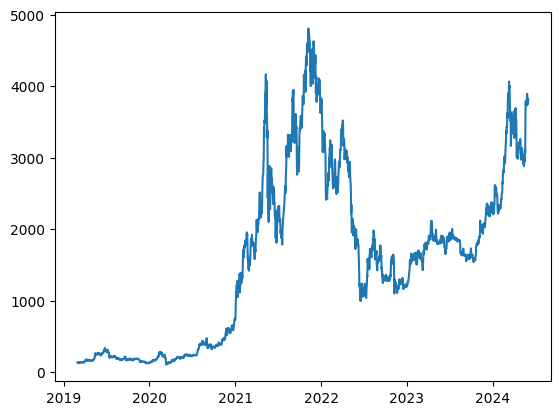

In [68]:
#df['Price'].plot(figsize=(10,5),color='red')

plt.plot(eth_df['Price'])

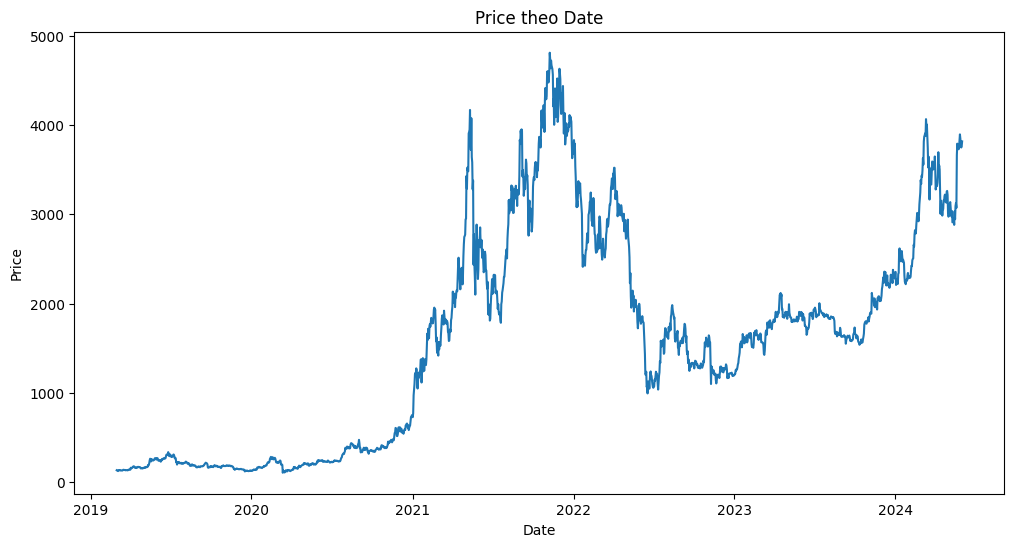

In [88]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Price', data=eth_df)

plt.title('Price theo Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

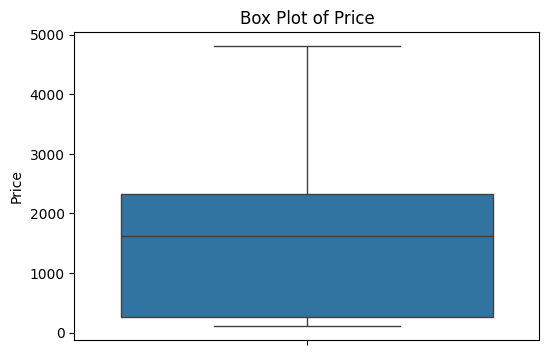

In [89]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=eth_df, y='Price')
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

In [90]:
plt.figure(figsize=(8, 6))
sns.histplot(eth_df['Date'], bins=20, kde=True)
plt.title('Histogram of Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

KeyError: 'Date'

<Figure size 800x600 with 0 Axes>

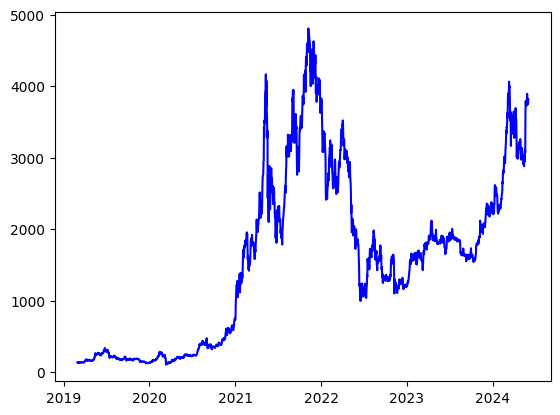

In [91]:
plt.figure()
plt.plot(eth_df["Price"], color='blue')
plt.show()

<Axes: >

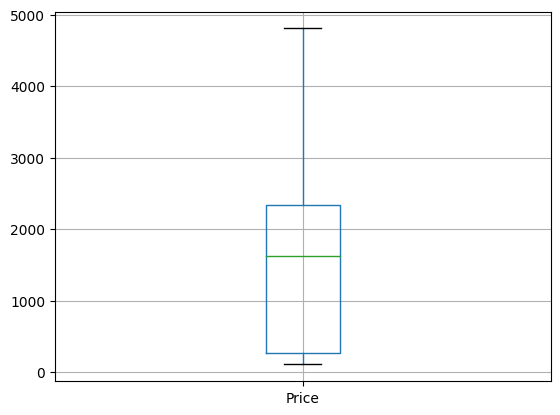

In [92]:
eth_df.boxplot(column=['Price'])

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(eth_df.corr(),annot =True,cmap="YlGnBu")

### Preprocess data ###

In [80]:

eth_df['Year'] = eth_df.index.year
eth_df['Month'] = eth_df.index.month
eth_df['Day'] = eth_df.index.day

In [81]:
eth_df


,Price,Open,High,Low,Vol.,Change %,Year,Month,Day
Date,,,,,,,,,
2024-06-01,3815.95,3762.63,3832.35,3753.32,143810.0,0.0142,2024,6,1
2024-05-31,3762.66,3747.89,3844.96,3724.57,294560.0,0.0040,2024,5,31
2024-05-30,3747.55,3767.22,3824.94,3703.74,293810.0,-0.0058,2024,5,30
2024-05-29,3769.57,3845.56,3886.44,3745.72,353250.0,-0.0198,2024,5,29
2024-05-28,3845.56,3894.33,3929.21,3775.08,436240.0,-0.0125,2024,5,28
...,...,...,...,...,...,...,...,...,...
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861,2019,3,5
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385,2019,3,4
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132,2019,3,3


In [83]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
 6   Year      1920 non-null   int32  
 7   Month     1920 non-null   int32  
 8   Day       1920 non-null   int32  
dtypes: float64(6), int32(3)
memory usage: 127.5 KB


In [86]:
eth_df.shape

(1920, 9)

**Split data**

In [87]:
df_train = eth_df[eth_df.index<='3/1/2024']
df_test = eth_df[eth_df.index>'3/1/2024']

In [93]:
print('df_train.shape: ',df_train.shape)
print('df_trest.shape: ',df_test.shape)

df_train.shape:  (1828, 9)
df_trest.shape:  (92, 9)


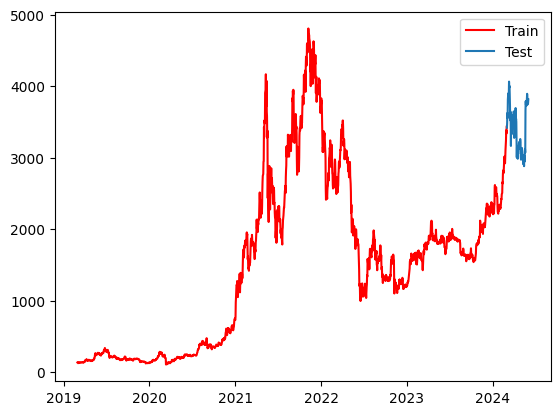

In [95]:
plt.figure()
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']), label ='Test')
plt.legend()
plt.show()

In [96]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)

In [105]:
X_train_flat = df_train_scaled.drop(columns=['Price'])
y_train_flat = df_train_scaled['Price']
X_test_flat = df_test_scaled.drop(columns=['Price'])
y_test_flat = df_test_scaled['Price']

In [106]:
X_train_flat = df_train_scaled.drop(columns=['Price'])
y_train_flat = df_train_scaled['Price']
X_test_flat = df_test_scaled.drop(columns=['Price'])
y_test_flat = df_test_scaled['Price']

In [107]:
def train_test_split(X_train, y_train,X_test,y_test,test_size, window_size=10):
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test

In [109]:
# Define window_size with an appropriate value
window_size = 5  # or any other value that makes sense in your context

# Now you can use window_size in your function call
X_train, y_train, X_test, y_test = train_test_split(X_train_flat, y_train_flat, X_test_flat, y_test_flat, window_size)


In [110]:
X_train, y_train, X_test, y_test=train_test_split(X_train_flat,y_train_flat,X_test_flat,y_test_flat,window_size)

In [111]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1818, 10, 8)
y_train shape:  (1818,)
X_test shape:  (82, 10, 8)
y_test shape:  (82,)


In [112]:
from sklearn.model_selection import train_test_split

In [113]:
x = eth_df.drop(['Price'],axis =1 ).values
y = eth_df['Change %'].values

In [114]:
new_df=eth_df.drop[['Price', 'Change %']]
X =new_df.drop(['Price'],axis = 1)
y = new_df['Change %']

TypeError: 'method' object is not subscriptable

In [115]:
x

array([[3.76263e+03, 3.83235e+03, 3.75332e+03, ..., 2.02400e+03,
        6.00000e+00, 1.00000e+00],
       [3.74789e+03, 3.84496e+03, 3.72457e+03, ..., 2.02400e+03,
        5.00000e+00, 3.10000e+01],
       [3.76722e+03, 3.82494e+03, 3.70374e+03, ..., 2.02400e+03,
        5.00000e+00, 3.00000e+01],
       ...,
       [1.32770e+02, 1.68420e+02, 1.29050e+02, ..., 2.01900e+03,
        3.00000e+00, 3.00000e+00],
       [1.35720e+02, 1.36360e+02, 1.30740e+02, ..., 2.01900e+03,
        3.00000e+00, 2.00000e+00],
       [1.35470e+02, 1.38060e+02, 1.28460e+02, ..., 2.01900e+03,
        3.00000e+00, 1.00000e+00]])

In [116]:
y

array([ 0.0142,  0.004 , -0.0058, ..., -0.0132, -0.0218,  0.0018])

In [117]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [118]:
x_train

array([[1.28533e+03, 1.31047e+03, 1.27279e+03, ..., 2.02200e+03,
        1.00000e+01, 2.00000e+01],
       [1.82078e+03, 1.82432e+03, 1.77581e+03, ..., 2.02300e+03,
        4.00000e+00, 2.00000e+00],
       [2.61808e+03, 2.71288e+03, 2.46293e+03, ..., 2.02400e+03,
        1.00000e+00, 1.20000e+01],
       ...,
       [2.41252e+03, 2.54719e+03, 2.37385e+03, ..., 2.02200e+03,
        1.00000e+00, 2.30000e+01],
       [2.37900e+02, 2.44760e+02, 2.33840e+02, ..., 2.02000e+03,
        6.00000e+00, 3.00000e+00],
       [2.94504e+03, 2.98452e+03, 2.85412e+03, ..., 2.02100e+03,
        5.00000e+00, 2.00000e+00]])

In [119]:
y_train

array([-0.0019, -0.0142, -0.0359, ...,  0.0532,  0.0277,  0.0019])

In [121]:
print('X_scale.shape: ',X_scale.shape)
print('y_scale.shape: ',y_scale.shape)

NameError: name 'X_scale' is not defined

In [123]:
X_train, y_train, X_test, y_test = train_test_split(X_scale, y_scale, 0.2, 10)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)

NameError: name 'X_scale' is not defined